# Images of the beam on the grid mirrors:

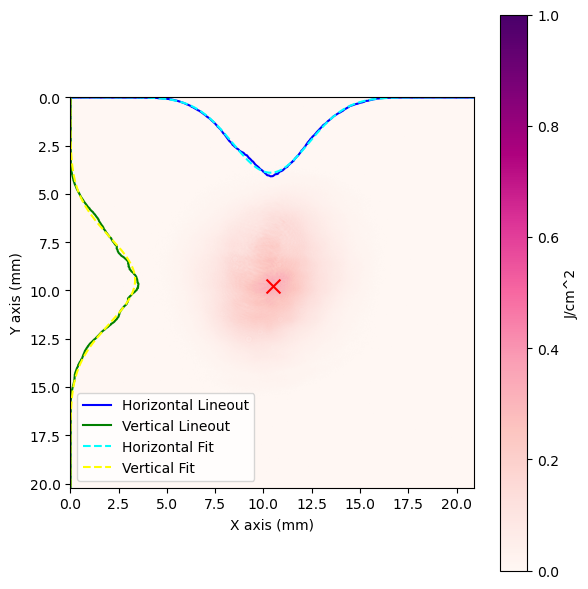

File: 6_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.8885 mm
Vertical 1/e^2 Diameter: 8.9751 mm


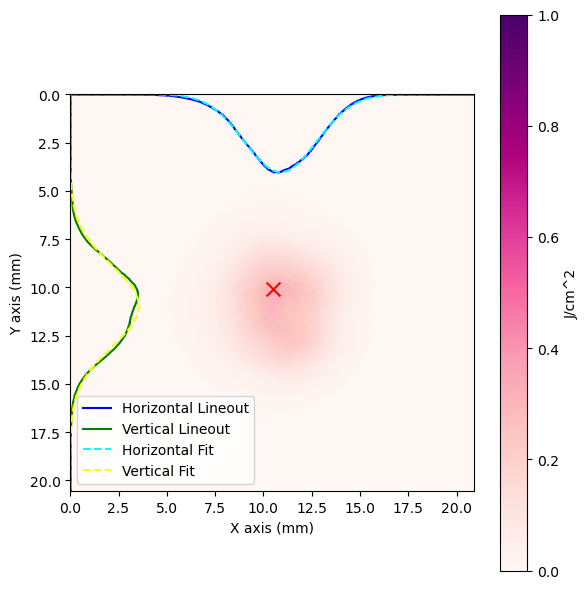

File: 7_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.4886 mm
Vertical 1/e^2 Diameter: 8.4809 mm


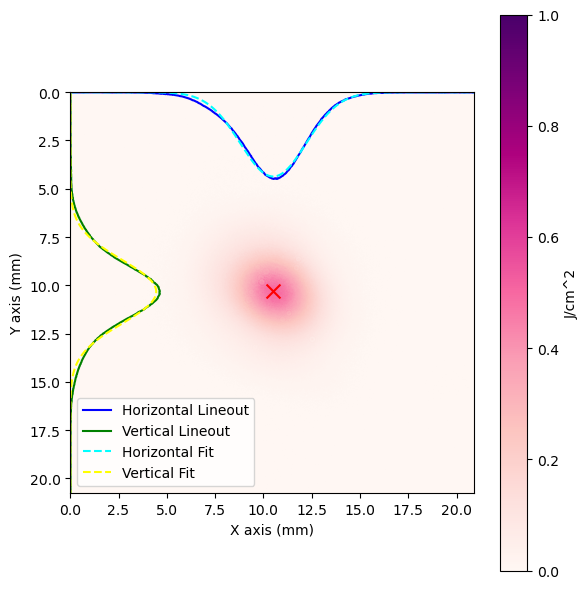

File: 8_0001.ascii.csv
Horizontal 1/e^2 Diameter: 6.8262 mm
Vertical 1/e^2 Diameter: 6.5465 mm


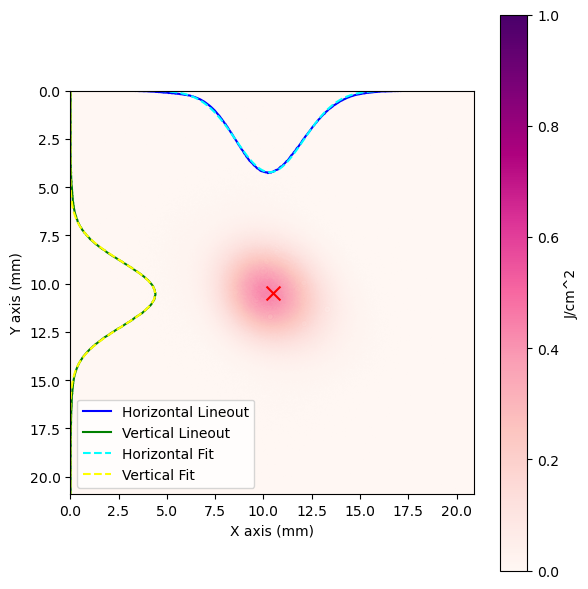

File: 9_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.0107 mm
Vertical 1/e^2 Diameter: 6.7317 mm


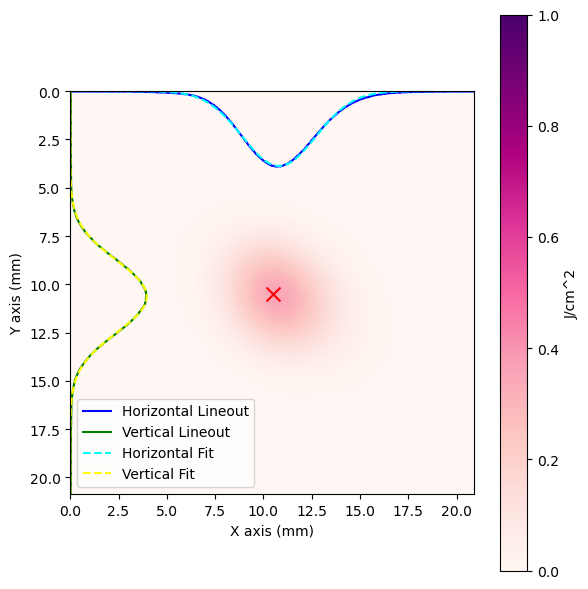

File: 10_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.6142 mm
Vertical 1/e^2 Diameter: 7.4885 mm
ValueError: Could not process 11_0001.ascii.csv: 'utf-8' codec can't decode byte 0x8a in position 0: invalid start byte


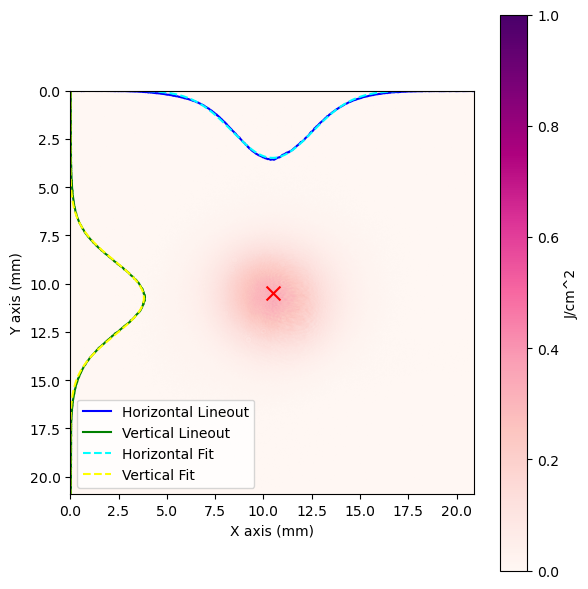

File: 12_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.3296 mm
Vertical 1/e^2 Diameter: 7.6303 mm


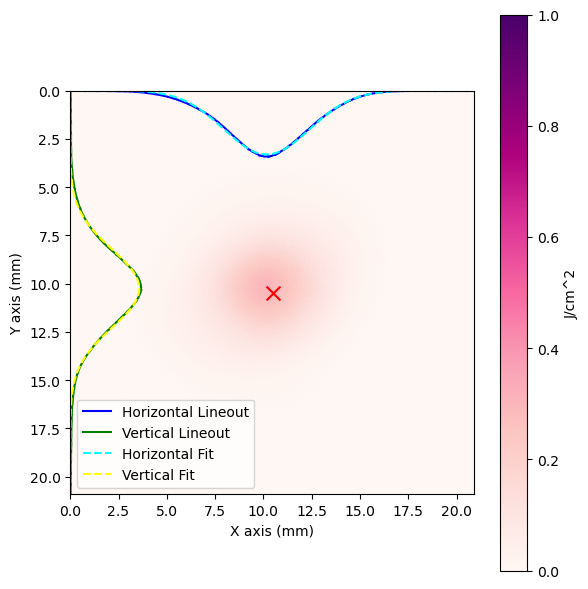

File: 13_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.8580 mm
Vertical 1/e^2 Diameter: 8.1031 mm


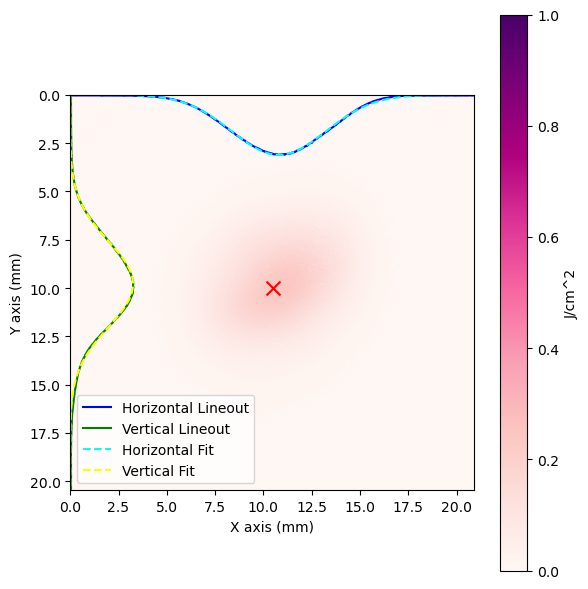

File: 14_0001.ascii.csv
Horizontal 1/e^2 Diameter: 9.7404 mm
Vertical 1/e^2 Diameter: 8.9427 mm


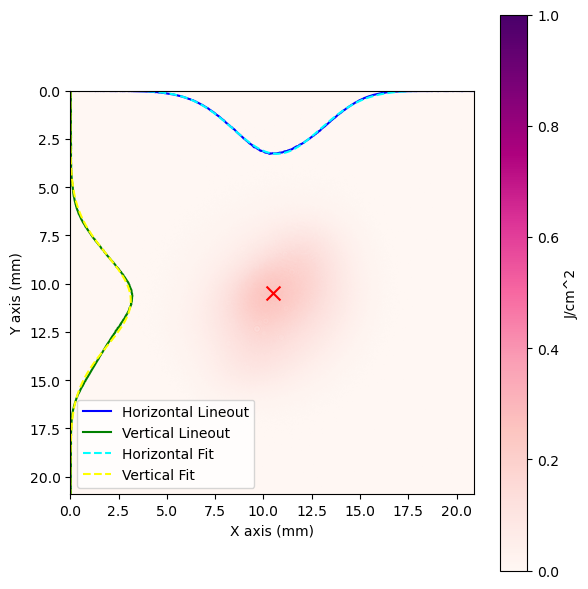

File: 15_0001.ascii.csv
Horizontal 1/e^2 Diameter: 9.0464 mm
Vertical 1/e^2 Diameter: 9.4534 mm


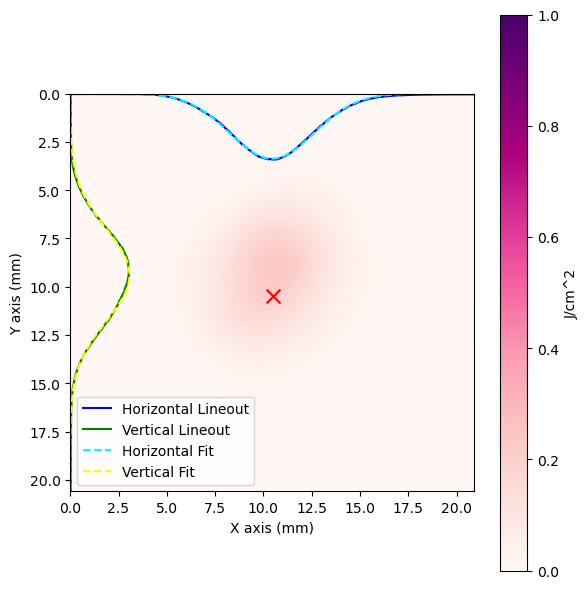

File: 16_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.7308 mm
Vertical 1/e^2 Diameter: 9.6301 mm


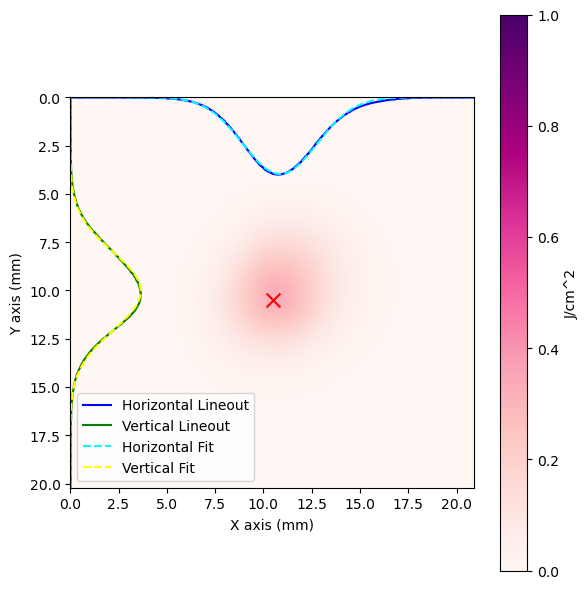

File: 17_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.6767 mm
Vertical 1/e^2 Diameter: 8.1394 mm


In [212]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

E_beam = 80e-3  # 100 mJ in a pulse
dx = 4*8.73e-6  # pixel size of the spiricon camera (9 microns) - and 4 pixel binning!
A_pix_cm = dx**2 * 1e4  # pixel area in cm^2

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_gaussian(data):
    x = np.arange(len(data))
    initial_guess = [np.max(data), len(data) // 2, len(data) / 10]
    try:
        popt, _ = curve_fit(gaussian, x, data, p0=initial_guess)
        return popt
    except RuntimeError:
        return None

def plot_ascii_csv_files_with_peak(folder_path,ascii_csv_files):

    max_fluences = []
    h_diams = []
    v_diams = []

    # Plot each ASCII CSV file
    for csv_file in ascii_csv_files:
        file_path = os.path.join(folder_path, csv_file)
        try:
            # Load the CSV file into a numpy array
            data = np.genfromtxt(file_path, delimiter=',')

            # Replace NaN or inf values with zeros
            data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

            # Find the peak value in the data
            peak_value = np.max(data)

            # Replace all pixel values less than 1% of the peak value with zeros
            threshold = 0.01 * peak_value
            data[data < threshold] = 0

            sum_vals = np.sum(data)  # sum of all the pixel counts
            E_per_pixcount = E_beam / sum_vals  # energy per one pixel count

            # Find the peak in the data
            max_loc = np.unravel_index(np.argmax(data), data.shape)

            # Create a mask for a circle with radius 5 pixels around the peak location
            y, x = np.ogrid[:data.shape[0], :data.shape[1]]
            center_y, center_x = max_loc
            mask = (x - center_x)**2 + (y - center_y)**2 <= 5**2

            # Apply the mask to the data to get the values within the circle
            values_in_circle = data[mask]

            # Calculate the average value within the peak circle
            avg_peak = np.mean(values_in_circle)

            #save the peak fluence
            max_fluences.append(avg_peak * E_per_pixcount / A_pix_cm)

            # Crop the data to a 600x600 pixel square centered on the peak
            center_y, center_x = max_loc
            start_x = max(center_x - 300, 0)
            end_x = min(center_x + 300, data.shape[1])
            start_y = max(center_y - 300, 0)
            end_y = min(center_y + 300, data.shape[0])
            cropped_data = data[start_y:end_y, start_x:end_x]

            # Calculate the fluence
            fluence_map = cropped_data * E_per_pixcount / A_pix_cm

            # Extract the lineouts for gaussian fitting (sum along axis)
            horizontal_lineout = np.mean(fluence_map,axis=0)
            vertical_lineout = np.mean(fluence_map,axis=1)

            # Fit Gaussian to the lineouts
            h_fit_params = fit_gaussian(horizontal_lineout)
            v_fit_params = fit_gaussian(vertical_lineout)

            # Calculate the 1/e^2 diameters
            if h_fit_params is not None:
                h_fwhm = 2 * np.sqrt(2*np.log(2)) * h_fit_params[2] #calculate FWHM from sigma
                h_esqr_mm = 1.699 * h_fwhm * dx * 1e3  # convert FWHM to 1/e^2 diameter, and into mm
                h_diams.append(h_esqr_mm)
            else:
                h_esqr_mm = None

            if v_fit_params is not None:
                v_fwhm = 2 * np.sqrt(2) * np.sqrt(np.log(2)) * v_fit_params[2] #calculate FWHM from sigma
                v_esqr_mm = 1.699 * v_fwhm * dx * 1e3 # convert FWHM to 1/e^2 diameter, and into mm
                v_diams.append(v_esqr_mm)
            else:
                v_esqr_mm = None

            # Create mm scales for the axes
            x_mm = np.arange(fluence_map.shape[1]) * dx * 1e3
            y_mm = np.arange(fluence_map.shape[0]) * dx * 1e3

            # Plot the data using matplotlib
            fig, ax = plt.subplots(figsize=(6, 6))

            # Plot the fluence map
            im = ax.imshow(fluence_map, extent=[x_mm[0], x_mm[-1], y_mm[-1], y_mm[0]], cmap='RdPu', vmin=0, vmax=1)
            ax.scatter((center_x-start_x) * dx * 1e3, (center_y-start_y) * dx * 1e3, color='red', s=100, marker='x')
            ax.set_xlabel('X axis (mm)')
            ax.set_ylabel('Y axis (mm)')
            plt.colorbar(im, ax=ax, label='J/cm^2')

            lfactor = 50
            # Overlay the lineouts
            ax.plot(x_mm, horizontal_lineout * lfactor, color='blue', label='Horizontal Lineout')
            ax.plot(vertical_lineout * lfactor, y_mm, color='green', label='Vertical Lineout')

            # Overlay the Gaussian fits
            if h_fit_params is not None:
                ax.plot(x_mm, gaussian(np.arange(len(x_mm)), *h_fit_params)*lfactor, color='cyan', linestyle='--', label='Horizontal Fit')
            if v_fit_params is not None:
                ax.plot(gaussian(np.arange(len(y_mm)), *v_fit_params) * lfactor, y_mm, color='yellow', linestyle='--', label='Vertical Fit')

            ax.legend()

            plt.tight_layout()
            plt.show()

            print(f"File: {csv_file}")
            print(f"Horizontal 1/e^2 Diameter: {h_esqr_mm:.4f} mm" if h_esqr_mm else "Horizontal fit failed")
            print(f"Vertical 1/e^2 Diameter: {v_esqr_mm:.4f} mm" if v_esqr_mm else "Vertical fit failed")

        except ValueError as ve:
            print(f"ValueError: Could not process {csv_file}: {ve}")
        except Exception as e:
            print(f"Could not process {csv_file}: {e}")

    return max_fluences,h_diams,v_diams

# Example usage:
folder_path_1 = '/Users/sebastiankalos/Documents/OXFORD/CALA/Expt_June2024/21062024/grid1'
ascii_csv_files_1 = ['6_0001.ascii.csv',
                        '7_0001.ascii.csv',
                        '8_0001.ascii.csv',
                        '9_0001.ascii.csv',
                        '10_0001.ascii.csv',
                        '11_0001.ascii.csv',
                        '12_0001.ascii.csv',
                        '13_0001.ascii.csv',
                        '14_0001.ascii.csv',
                        '15_0001.ascii.csv',
                        '16_0001.ascii.csv',
                        '17_0001.ascii.csv']
max_fluences_1,h_diams_1,v_diams_1 = plot_ascii_csv_files_with_peak(folder_path_1, ascii_csv_files_1)


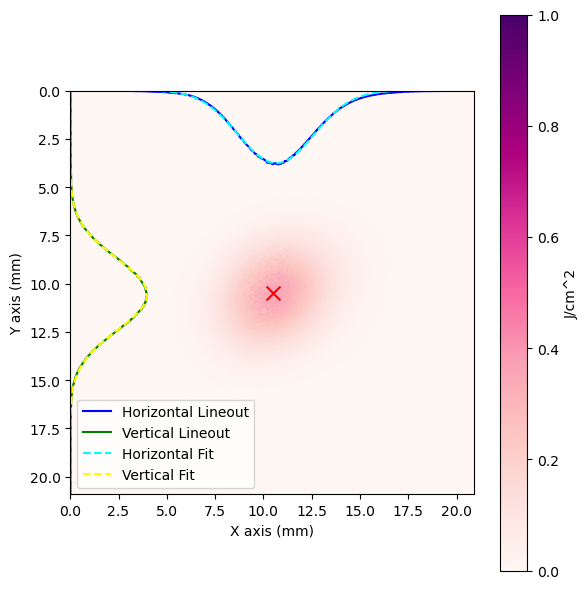

File: 1_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.8229 mm
Vertical 1/e^2 Diameter: 7.5154 mm


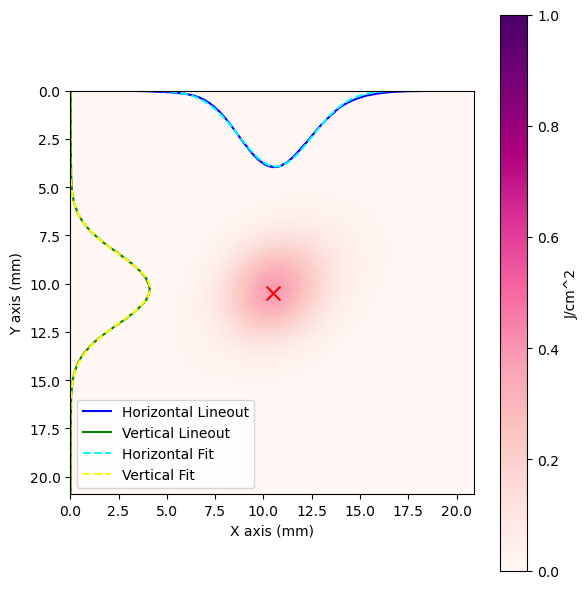

File: 2_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.5059 mm
Vertical 1/e^2 Diameter: 7.2233 mm


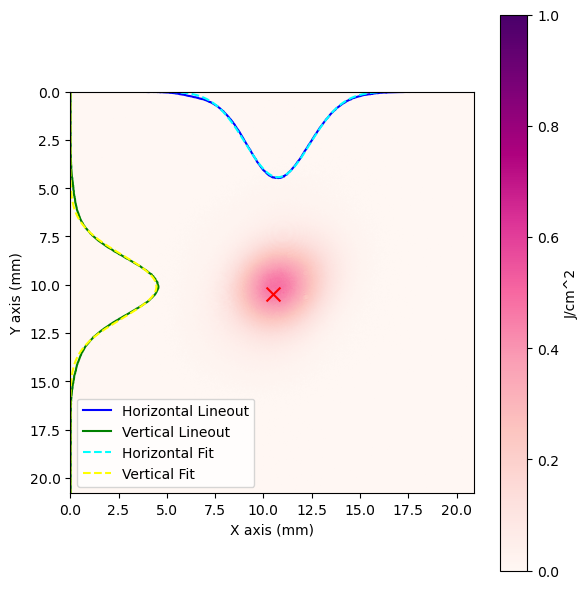

File: 3_0001.ascii.csv
Horizontal 1/e^2 Diameter: 6.6868 mm
Vertical 1/e^2 Diameter: 6.5232 mm


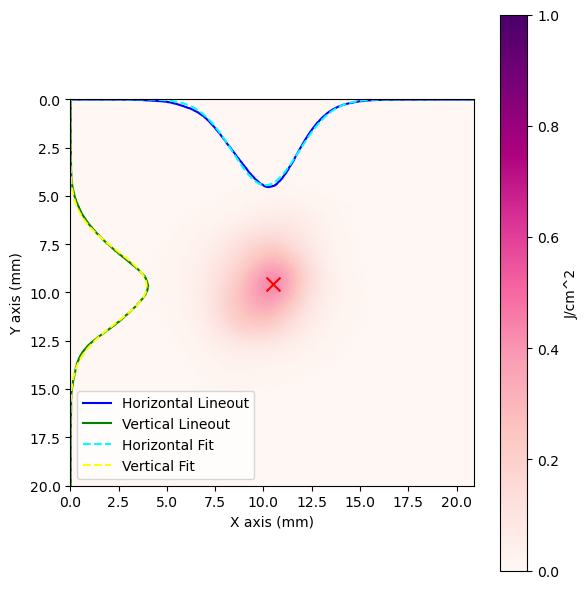

File: 4_0001.ascii.csv
Horizontal 1/e^2 Diameter: 6.9016 mm
Vertical 1/e^2 Diameter: 7.4630 mm


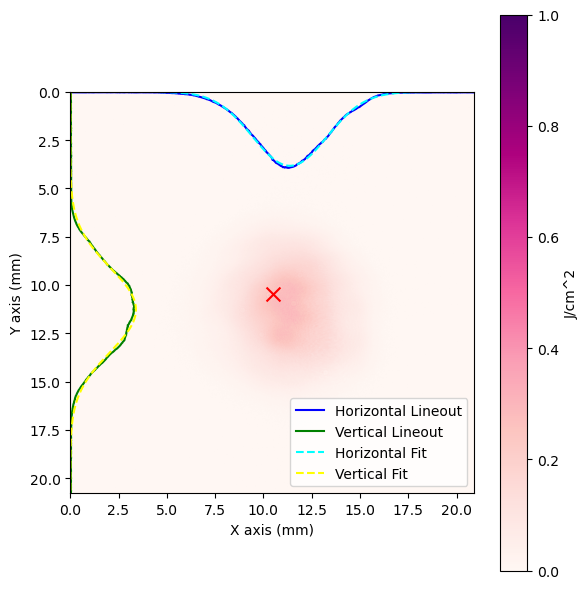

File: 5_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.6990 mm
Vertical 1/e^2 Diameter: 8.7752 mm


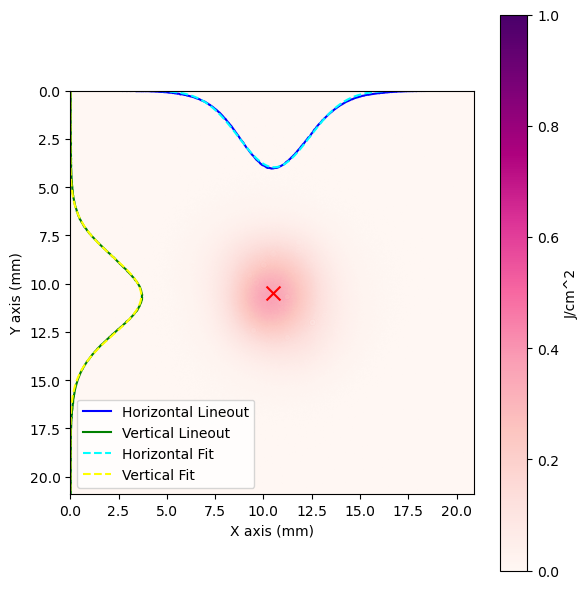

File: 6_0001.ascii.csv
Horizontal 1/e^2 Diameter: 7.3588 mm
Vertical 1/e^2 Diameter: 8.0140 mm


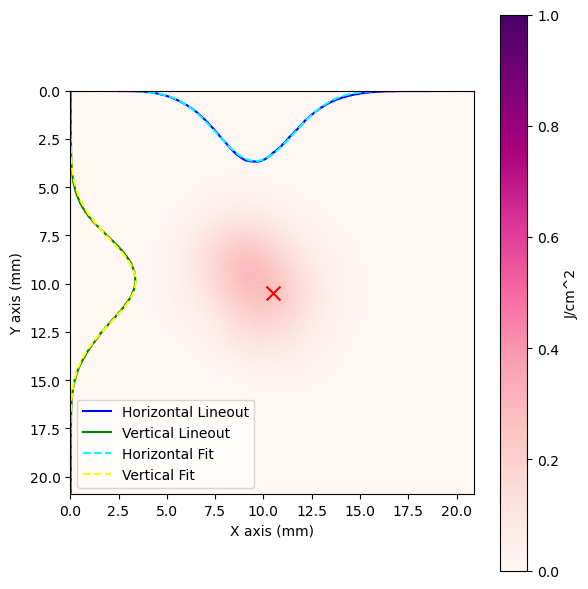

File: 7_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.0156 mm
Vertical 1/e^2 Diameter: 8.7025 mm
ValueError: Could not process 8_0001.ascii.csv: 'utf-8' codec can't decode byte 0xf5 in position 4096: invalid start byte
ValueError: Could not process 9_0001.ascii.csv: 'utf-8' codec can't decode byte 0xd1 in position 4096: invalid continuation byte


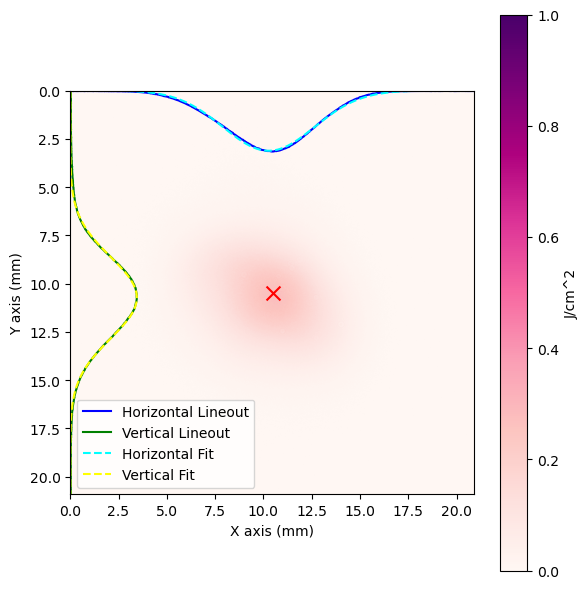

File: 10_0001.ascii.csv
Horizontal 1/e^2 Diameter: 9.4694 mm
Vertical 1/e^2 Diameter: 8.4513 mm


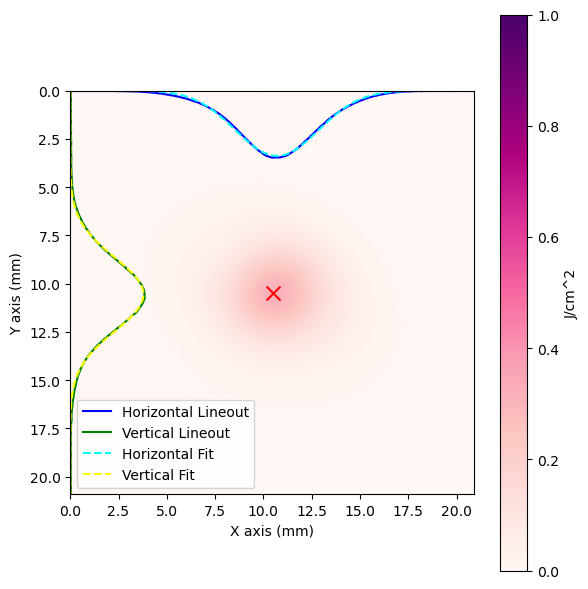

File: 11_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.5985 mm
Vertical 1/e^2 Diameter: 7.6807 mm


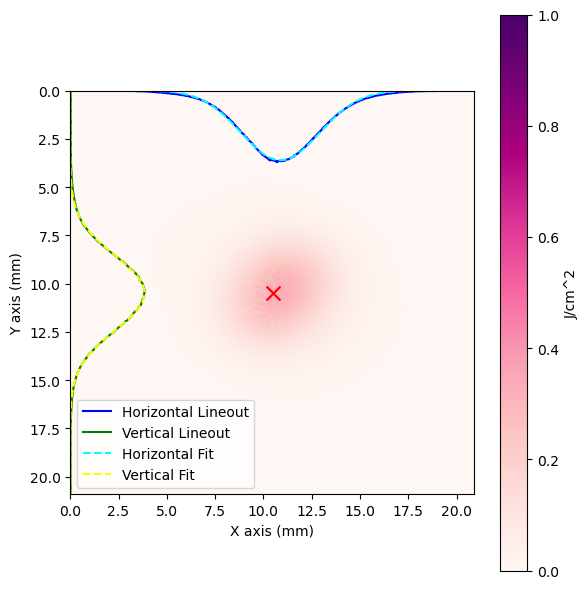

File: 12_0001.ascii.csv
Horizontal 1/e^2 Diameter: 8.1224 mm
Vertical 1/e^2 Diameter: 7.7169 mm


In [213]:
# Example usage:
folder_path_2 = '/Users/sebastiankalos/Documents/OXFORD/CALA/Expt_June2024/21062024/grid2'
ascii_csv_files_2 = ['1_0001.ascii.csv',
                        '2_0001.ascii.csv',
                        '3_0001.ascii.csv',
                        '4_0001.ascii.csv',
                        '5_0001.ascii.csv',
                        '6_0001.ascii.csv',
                        '7_0001.ascii.csv',
                        '8_0001.ascii.csv',
                        '9_0001.ascii.csv',
                        '10_0001.ascii.csv',
                        '11_0001.ascii.csv',
                        '12_0001.ascii.csv']
max_fluences_2,h_diams_2,v_diams_2 = plot_ascii_csv_files_with_peak(folder_path_2, ascii_csv_files_2)

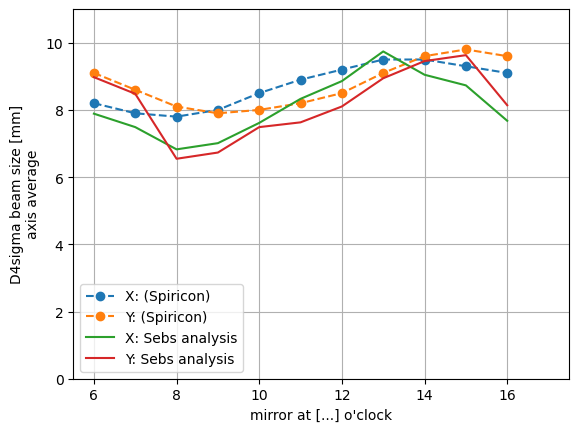

In [250]:
mirrs_42 = [6,7,8,9,10,11,12,13,14,15,16]
x42 = [8.2,7.9,7.8,8.0,8.5,8.9,9.2,9.5,9.5,9.3,9.1]
y42 = [9.1,8.6,8.1,7.9,8.0,8.2,8.5,9.1,9.6,9.8,9.6]

plt.plot(mirrs_42,x42,'--o',label='X: (Spiricon)')
plt.plot(mirrs_42,y42,'--o',label='Y: (Spiricon)')

plt.plot(mirrs_42,h_diams_1,label='X: Sebs analysis')
plt.plot(mirrs_42,v_diams_1,label='Y: Sebs analysis')


plt.xlim(5.5,17.5)
plt.ylim(0,11)
plt.grid()

plt.xlabel("mirror at [...] o'clock")
plt.ylabel('D4sigma beam size [mm]\naxis average')
plt.legend()

(0.0, 0.5)

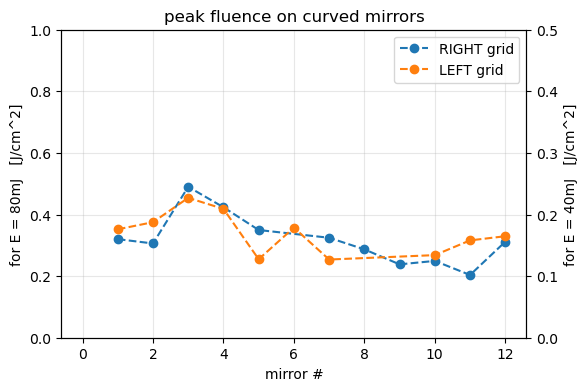

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))

mirrs_1 = [1,2,3,4,5,7,8,9,10,11,12]
mirrs_2 = [1,2,3,4,5,6,7,10,11,12]

ax.plot(mirrs_1,max_fluences_1,'--o',label='RIGHT grid')
ax.plot(mirrs_2,max_fluences_2,'--o',label='LEFT grid')
ax.set_xlabel('mirror #')
ax.set_ylabel(r'for E = 80mJ   [J/cm^2]')
ax.set_ylim(0,1)
ax.set_title('peak fluence on curved mirrors')
ax.grid(alpha=0.3)
ax.legend()

ax1 = ax.twinx()
ax1.plot(np.array(max_fluences_1)/2,alpha=0)
ax1.plot(np.array(max_fluences_2)/2,alpha=0)
ax1.set_ylabel(r'for E = 40mJ   [J/cm^2]')

ax1.set_ylim(0,0.5)



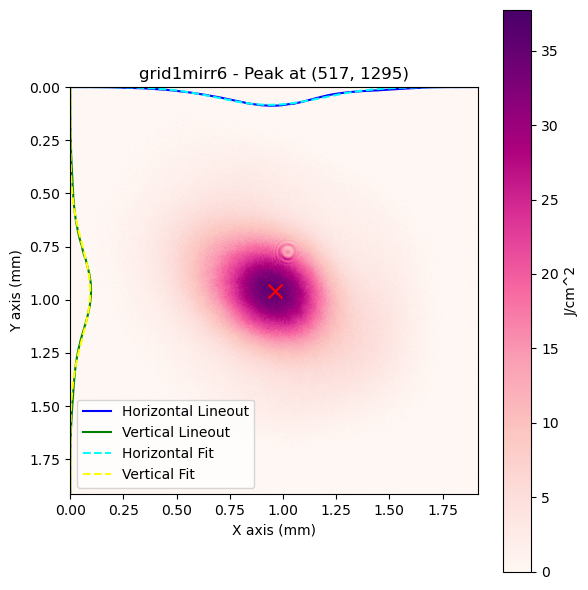

File: grid1mirr6
Horizontal 1/e^2 Diameter: 0.9724 mm
Vertical 1/e^2 Diameter: 0.8623 mm


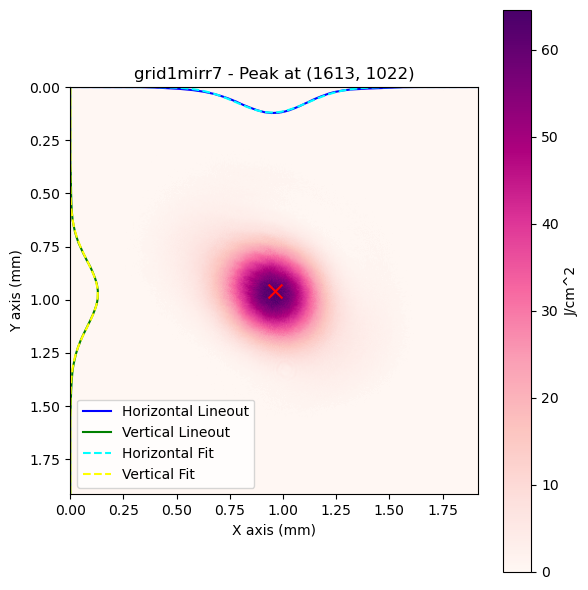

File: grid1mirr7
Horizontal 1/e^2 Diameter: 0.6699 mm
Vertical 1/e^2 Diameter: 0.6299 mm


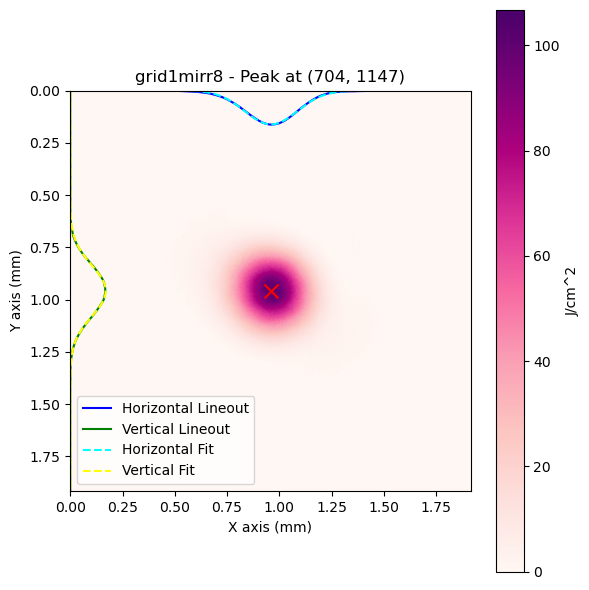

File: grid1mirr8
Horizontal 1/e^2 Diameter: 0.5049 mm
Vertical 1/e^2 Diameter: 0.4917 mm


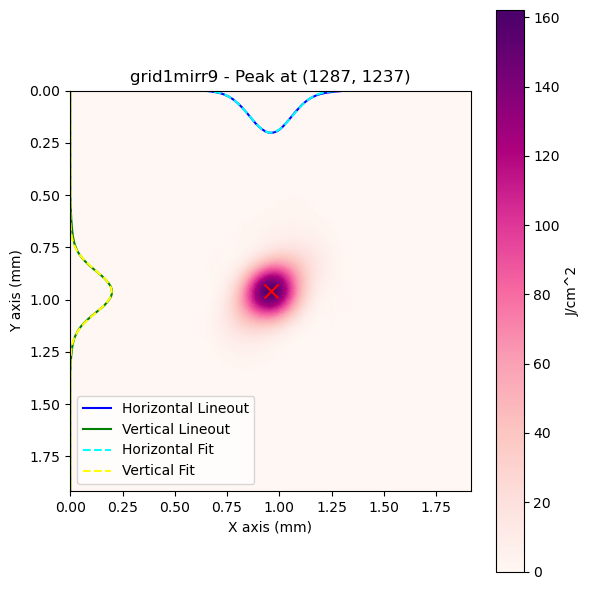

File: grid1mirr9
Horizontal 1/e^2 Diameter: 0.4092 mm
Vertical 1/e^2 Diameter: 0.4102 mm


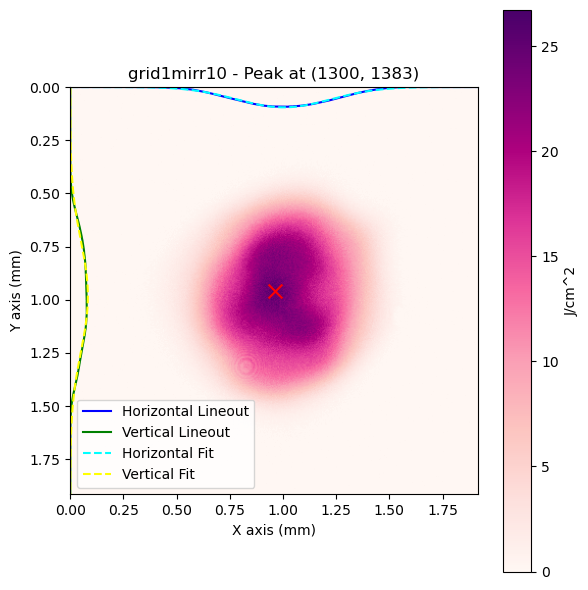

File: grid1mirr10
Horizontal 1/e^2 Diameter: 0.8873 mm
Vertical 1/e^2 Diameter: 1.0393 mm


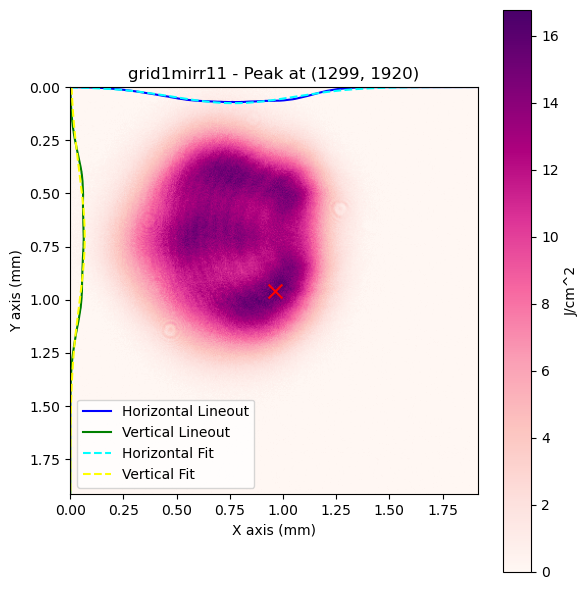

File: grid1mirr11
Horizontal 1/e^2 Diameter: 1.1350 mm
Vertical 1/e^2 Diameter: 1.2846 mm


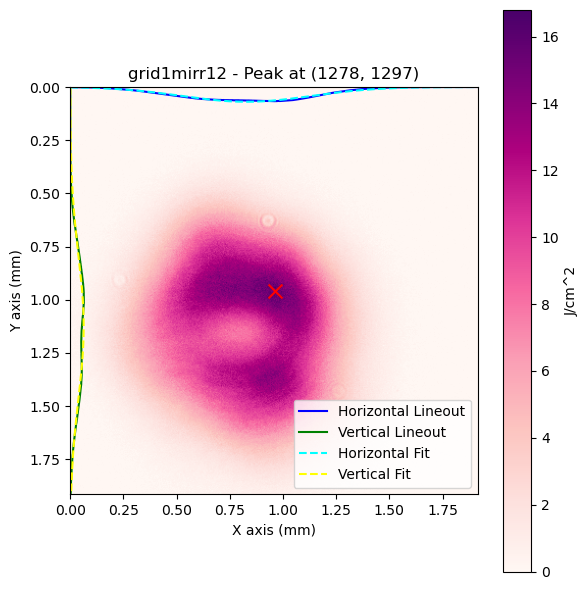

File: grid1mirr12
Horizontal 1/e^2 Diameter: 1.2209 mm
Vertical 1/e^2 Diameter: 1.3561 mm


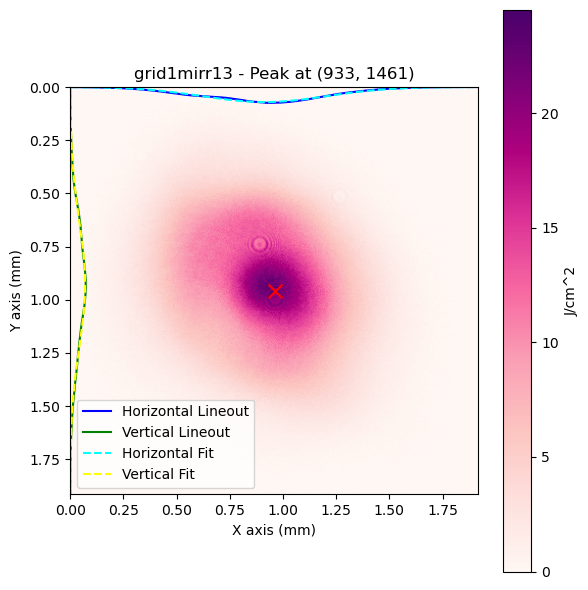

File: grid1mirr13
Horizontal 1/e^2 Diameter: 1.1717 mm
Vertical 1/e^2 Diameter: 1.1885 mm


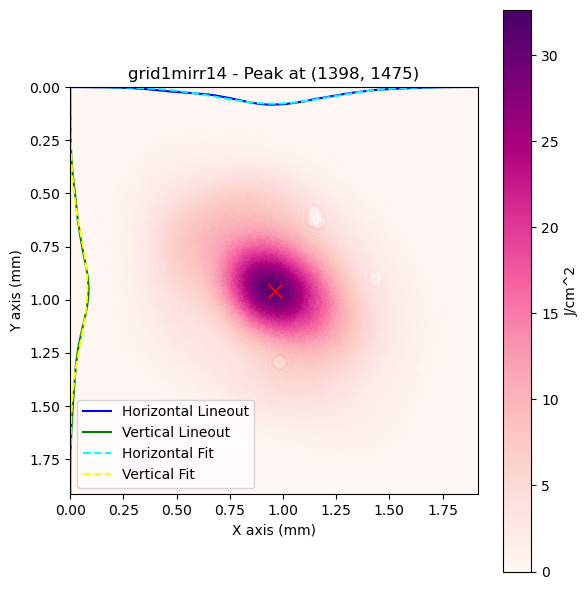

File: grid1mirr14
Horizontal 1/e^2 Diameter: 1.0498 mm
Vertical 1/e^2 Diameter: 1.0240 mm


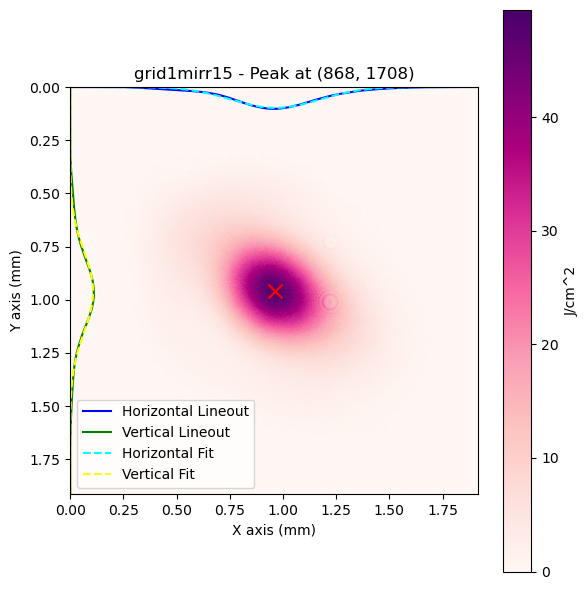

File: grid1mirr15
Horizontal 1/e^2 Diameter: 0.8212 mm
Vertical 1/e^2 Diameter: 0.7522 mm


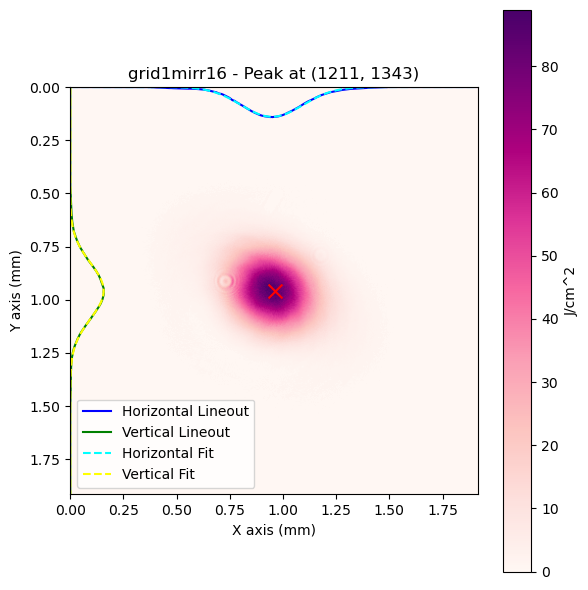

File: grid1mirr16
Horizontal 1/e^2 Diameter: 0.5778 mm
Vertical 1/e^2 Diameter: 0.5245 mm


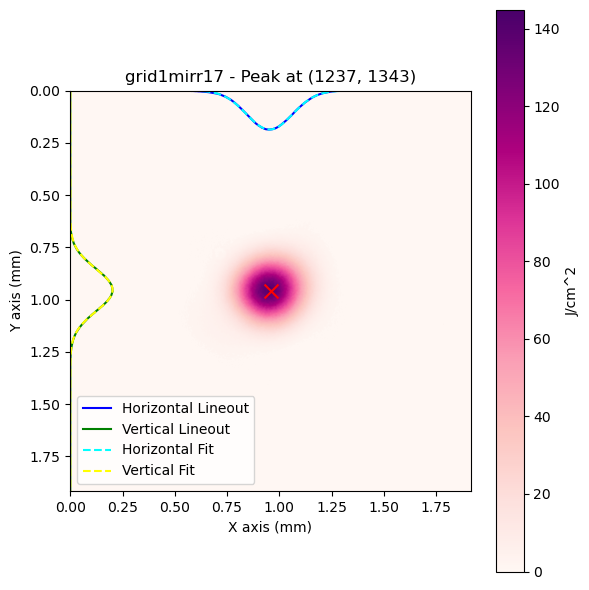

File: grid1mirr17
Horizontal 1/e^2 Diameter: 0.4403 mm
Vertical 1/e^2 Diameter: 0.4084 mm


In [254]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from PIL import Image
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

E_beam = 100e-3  # 100 mJ in a pulse
dx = 4.8e-6  # pixel size in meters (of the Basler camera, and with no binning!)
A_pix_cm = dx**2 * 1e4  # pixel area in cm^2

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_gaussian(data):
    x = np.arange(len(data))
    initial_guess = [np.max(data), len(data) // 2, len(data) / 10]
    try:
        popt, _ = curve_fit(gaussian, x, data, p0=initial_guess)
        return popt
    except RuntimeError:
        return None

def read_image_file(file_path):
    image = Image.open(file_path)
    data = np.array(image, dtype=np.float64)
    
    # Remove background
    background = data[:10, :10].mean()  # Assuming the top-left 10x10 pixels represent the background
    data -= background
    
    # Ensure no negative values after background subtraction
    data[data < 0] = 0
    
    return data


def plot_image_files_with_peak(folder_path, image_files):
    max_fluences = []
    h_diams = []
    v_diams = []

    # Plot each image file
    for image_file in image_files:
        cropped_imgs = []
        imnum_path = os.path.join(folder_path, image_file)
        for imnum in [' 01',' 02',' 03',' 04',' 05',' 06',' 07',' 08',' 09',' 10']:
            file_path = imnum_path+imnum+'.tiff'
        
            # Load the image file into a numpy array
            data = read_image_file(file_path)

            # Find the peak value in the data
            peak_value = np.max(data)

            # Replace all pixel values less than 3% of the peak value with zeros
            threshold = 0.01 * peak_value
            data[data < threshold] = 0

            # Find the peak in the data
            max_loc = np.unravel_index(np.argmax(data), data.shape)

            size = 200 #size of the cropped region (or rather half of it)

            # Create a mask for a circle with radius 5 pixels around the peak location
            y, x = np.ogrid[:data.shape[0], :data.shape[1]]
            center_y, center_x = max_loc

            # Crop the data to a 600x600 pixel square centered on the peak
            start_x = max(center_x - size, 0)
            end_x = min(center_x + size, data.shape[1])
            start_y = max(center_y - size, 0)
            end_y = min(center_y + size, data.shape[0])
            cropped_data = data[start_y:end_y, start_x:end_x]

            cropped_imgs.append(cropped_data)

        data = np.mean(np.array(cropped_imgs),axis=0)

        sum_vals = np.sum(data)  # sum of all the pixel counts
        E_per_pixcount = E_beam / sum_vals  # energy per one pixel count

        flat_list = [item for sublist in data for item in sublist]
    
        # Sort the list in descending order
        flat_list.sort(reverse=True)
        
        # Select the top 100 values
        top_100_values = flat_list[:100]
    
        # Calculate the average of the top 100 values
        avg_peak = sum(top_100_values) / 100

        max_fluences.append(avg_peak * E_per_pixcount / A_pix_cm)

        fluence_map = cropped_data * E_per_pixcount / A_pix_cm

        # Extract the lineouts
        horizontal_lineout = np.mean(fluence_map, axis=0)
        vertical_lineout = np.mean(fluence_map, axis=1)

        # Fit Gaussian to the lineouts
        h_fit_params = fit_gaussian(horizontal_lineout)
        v_fit_params = fit_gaussian(vertical_lineout)

        # Calculate the 1/e^2 diameters
        if h_fit_params is not None:
            h_fwhm = 2 * np.sqrt(2) * np.sqrt(np.log(2)) * h_fit_params[2]
            h_esqr_mm = 1.699 * h_fwhm * dx * 1e3  # convert to mm
            h_diams.append(h_esqr_mm)
        else:
            h_esqr_mm = None

        if v_fit_params is not None:
            v_fwhm = 2 * np.sqrt(2) * np.sqrt(np.log(2)) * v_fit_params[2]
            v_esqr_mm = 1.699 * v_fwhm * dx * 1e3  # convert to mm
            v_diams.append(v_esqr_mm)
        else:
            v_esqr_mm = None

        # Create mm scales for the axes
        x_mm = np.arange(fluence_map.shape[1]) * dx * 1e3
        y_mm = np.arange(fluence_map.shape[0]) * dx * 1e3

        # Plot the data using matplotlib
        fig, ax = plt.subplots(figsize=(6, 6))

        # Plot the fluence map
        im = ax.imshow(fluence_map, extent=[x_mm[0], x_mm[-1], y_mm[-1], y_mm[0]], cmap='RdPu')
        ax.scatter((center_x - start_x) * dx * 1e3, (center_y - start_y) * dx * 1e3, color='red', s=100, marker='x')
        ax.set_title(f"{image_file} - Peak at {max_loc}")
        ax.set_xlabel('X axis (mm)')
        ax.set_ylabel('Y axis (mm)')
        plt.colorbar(im, ax=ax, label='J/cm^2')

        fact = 0.01

        # Overlay the lineouts
        ax.plot(x_mm, horizontal_lineout * fact, color='blue', label='Horizontal Lineout')
        ax.plot(vertical_lineout * fact, y_mm, color='green', label='Vertical Lineout')

        # Overlay the Gaussian fits
        if h_fit_params is not None:
            ax.plot(x_mm, gaussian(np.arange(len(x_mm)), *h_fit_params) * fact, color='cyan', linestyle='--', label='Horizontal Fit')
        if v_fit_params is not None:
            ax.plot(gaussian(np.arange(len(y_mm)), *v_fit_params) * fact, y_mm, color='yellow', linestyle='--', label='Vertical Fit')

        ax.legend()

        plt.tight_layout()
        plt.show()

        print(f"File: {image_file}")
        print(f"Horizontal 1/e^2 Diameter: {h_esqr_mm:.4f} mm" if h_esqr_mm else "Horizontal fit failed")
        print(f"Vertical 1/e^2 Diameter: {v_esqr_mm:.4f} mm" if v_esqr_mm else "Vertical fit failed")

    return np.array(max_fluences), h_diams, v_diams

# Example usage:

foc_files_1 = ['grid1mirr6',
               'grid1mirr7',
               'grid1mirr8',
               'grid1mirr9',
               'grid1mirr10',
               'grid1mirr11',
               'grid1mirr12',
               'grid1mirr13',
               'grid1mirr14',
               'grid1mirr15',
               'grid1mirr16',
               'grid1mirr17']

folder_path = '/Users/sebastiankalos/Documents/OXFORD/HerriottCell/beam_sizes/hc_focus_240625'
max_fluences_1_foc, h_diams_1_foc, v_diams_1_foc = plot_image_files_with_peak(folder_path, foc_files_1)


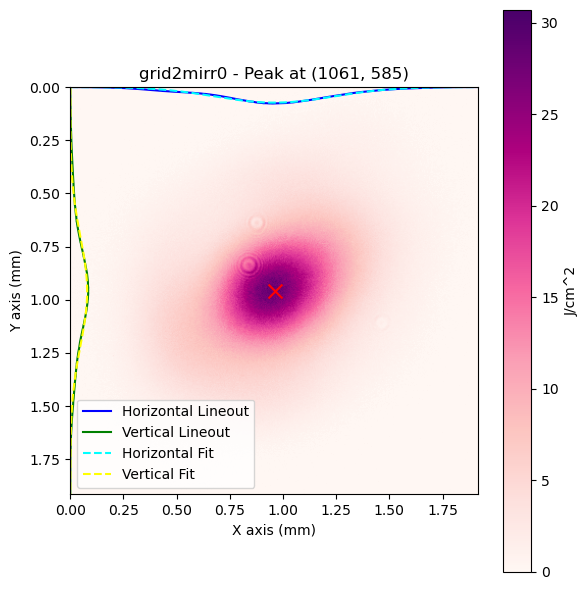

File: grid2mirr0
Horizontal 1/e^2 Diameter: 1.1116 mm
Vertical 1/e^2 Diameter: 1.0185 mm


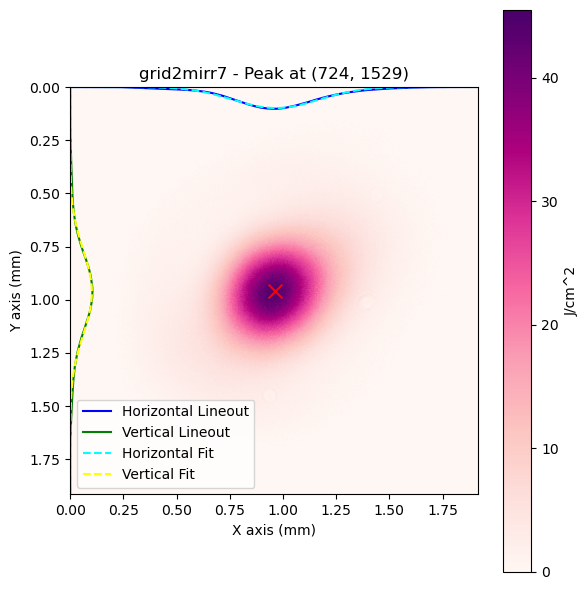

File: grid2mirr7
Horizontal 1/e^2 Diameter: 0.8031 mm
Vertical 1/e^2 Diameter: 0.7804 mm


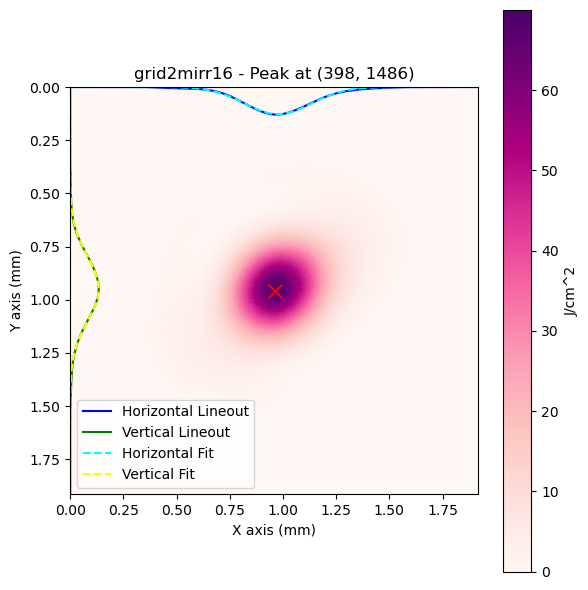

File: grid2mirr16
Horizontal 1/e^2 Diameter: 0.6307 mm
Vertical 1/e^2 Diameter: 0.6145 mm


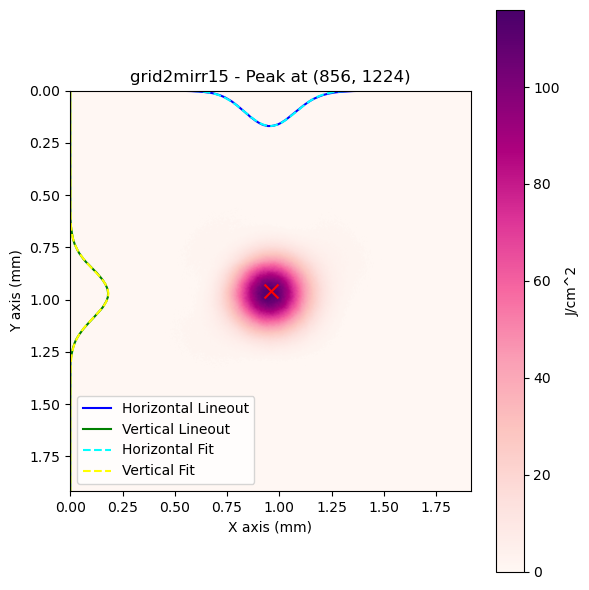

File: grid2mirr15
Horizontal 1/e^2 Diameter: 0.4861 mm
Vertical 1/e^2 Diameter: 0.4590 mm


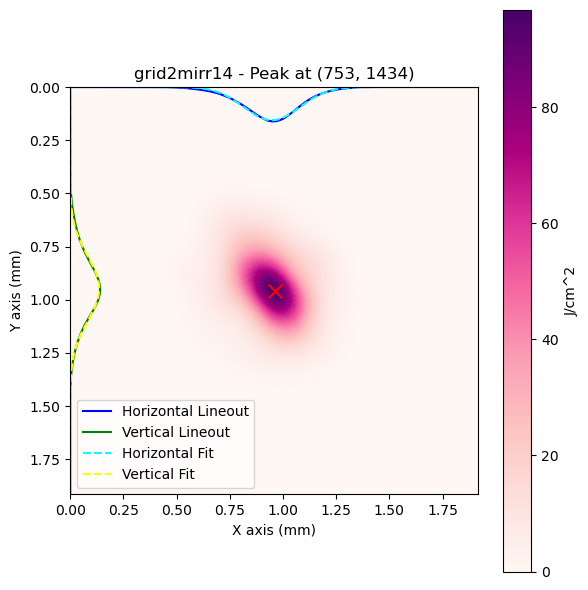

File: grid2mirr14
Horizontal 1/e^2 Diameter: 0.5242 mm
Vertical 1/e^2 Diameter: 0.6077 mm


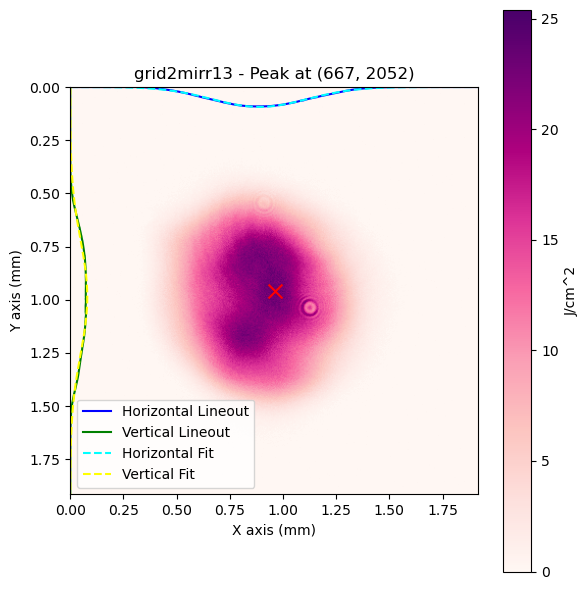

File: grid2mirr13
Horizontal 1/e^2 Diameter: 0.8986 mm
Vertical 1/e^2 Diameter: 1.0714 mm


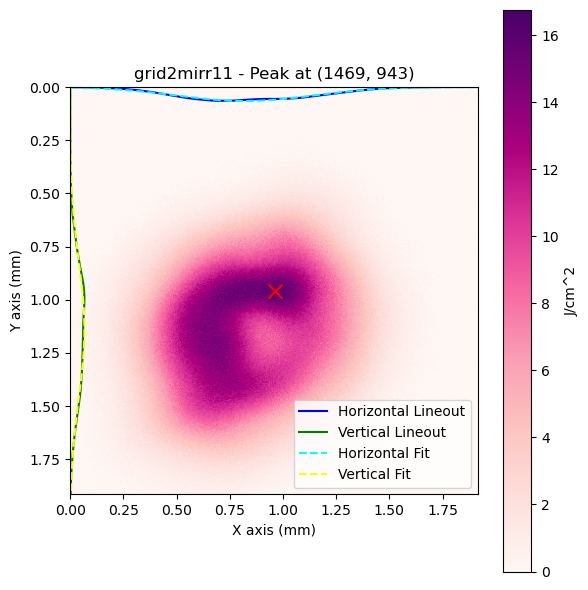

File: grid2mirr11
Horizontal 1/e^2 Diameter: 1.2810 mm
Vertical 1/e^2 Diameter: 1.2677 mm


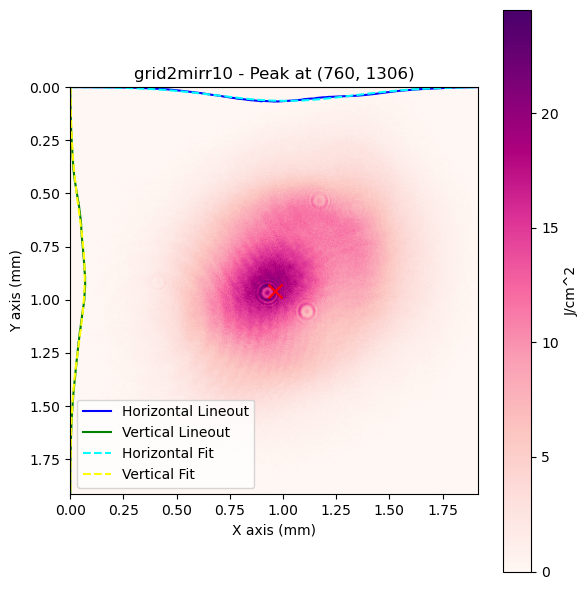

File: grid2mirr10
Horizontal 1/e^2 Diameter: 1.2816 mm
Vertical 1/e^2 Diameter: 1.2234 mm


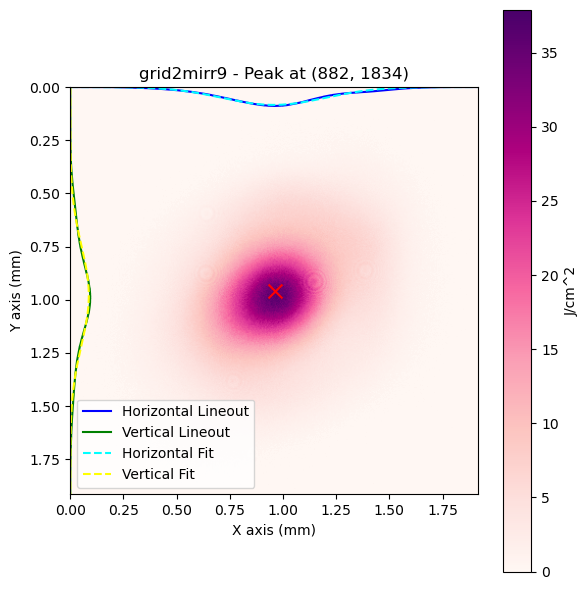

File: grid2mirr9
Horizontal 1/e^2 Diameter: 0.9664 mm
Vertical 1/e^2 Diameter: 0.9280 mm


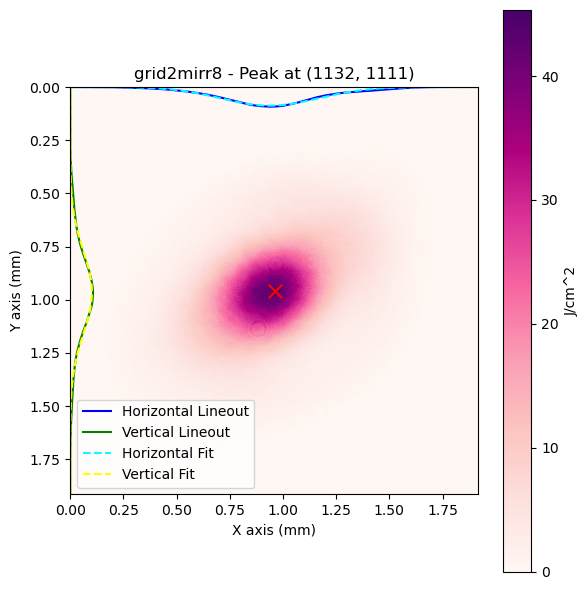

File: grid2mirr8
Horizontal 1/e^2 Diameter: 0.9162 mm
Vertical 1/e^2 Diameter: 0.7802 mm


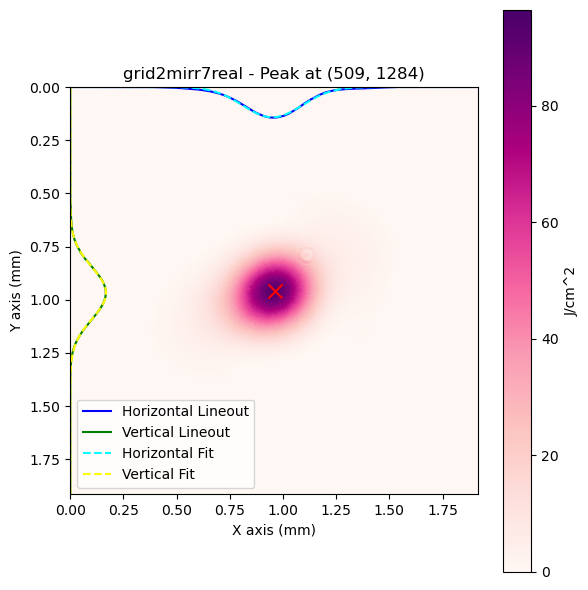

File: grid2mirr7real
Horizontal 1/e^2 Diameter: 0.5585 mm
Vertical 1/e^2 Diameter: 0.4893 mm


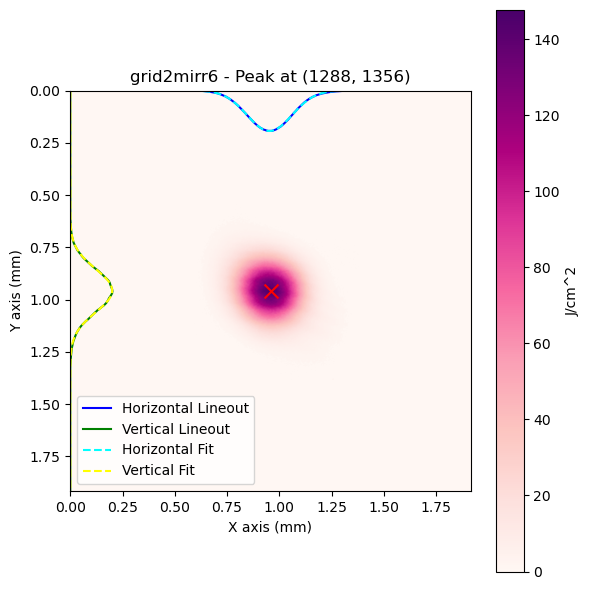

File: grid2mirr6
Horizontal 1/e^2 Diameter: 0.4298 mm
Vertical 1/e^2 Diameter: 0.4152 mm


In [255]:
foc_files_2 = ['grid2mirr0',
               'grid2mirr7',
               'grid2mirr16',
               'grid2mirr15',
               'grid2mirr14',
               'grid2mirr13',
               'grid2mirr11',
               'grid2mirr10',
               'grid2mirr9',
               'grid2mirr8',
               'grid2mirr7real',
               'grid2mirr6']

folder_path = '/Users/sebastiankalos/Documents/OXFORD/HerriottCell/beam_sizes/hc_focus_240625'
max_fluences_2_foc, h_diams_2_foc, v_diams_2_foc = plot_image_files_with_peak(folder_path, foc_files_2)

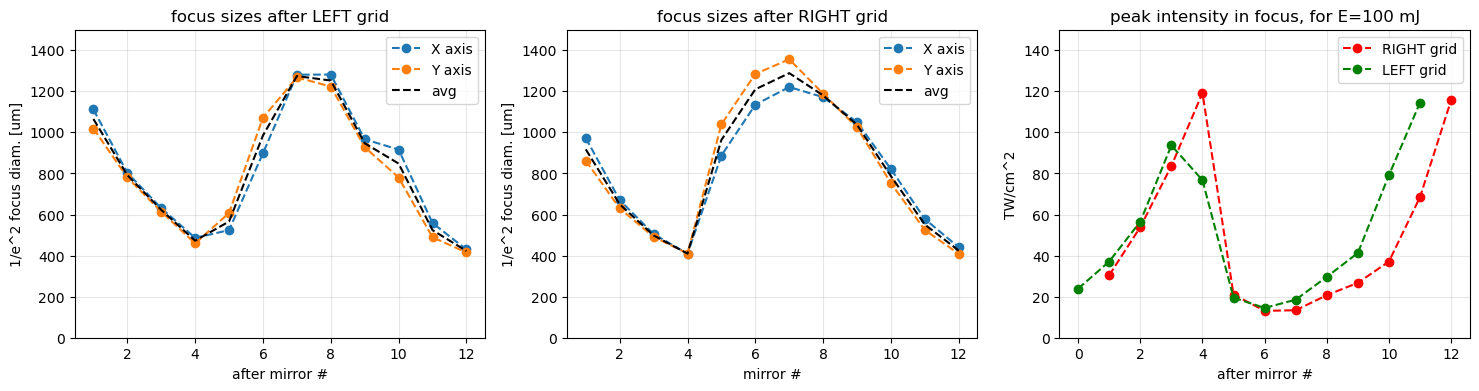

In [256]:
fig, ax = plt.subplots(1,3,figsize=(18, 4))

mirrs_1_foc = [1,2,3,4,5,6,7,8,9,10,11,12]
mirrs_2_foc = [1,2,3,4,5,6,7,8,9,10,11,12]

avg_foc_1 = (np.array(h_diams_1_foc)+np.array(v_diams_1_foc))/2 #find avg 
avg_foc_2 = (np.array(h_diams_2_foc)+np.array(v_diams_2_foc))/2

ax[0].plot(mirrs_2_foc,np.array(h_diams_2_foc)*1000,'--o',label='X axis')
ax[0].plot(mirrs_2_foc,np.array(v_diams_2_foc)*1000,'--o',label='Y axis')
ax[0].plot(mirrs_2_foc,avg_foc_2*1000,color='black',ls='dashed',label='avg')

ax[0].set_ylabel('1/e^2 focus diam. [um]')
ax[0].set_xlabel('after mirror #')
ax[0].legend()
ax[0].set_ylim(0,1500)
ax[0].set_title('focus sizes after LEFT grid')
ax[0].grid(alpha=0.3)

ax[1].plot(mirrs_1_foc,np.array(h_diams_1_foc)*1000,'--o',label='X axis')
ax[1].plot(mirrs_1_foc,np.array(v_diams_1_foc)*1000,'--o',label='Y axis')
avg_foc_1 = (np.array(h_diams_1_foc)+np.array(v_diams_1_foc))/2
ax[1].plot(mirrs_1_foc,avg_foc_1*1000,color='black',ls='dashed',label='avg')

ax[1].set_ylabel('1/e^2 focus diam. [um]')
ax[1].set_xlabel('mirror #')
ax[1].legend()
ax[1].set_ylim(0,1500)
ax[1].set_title('focus sizes after RIGHT grid')
ax[1].grid(alpha=0.3)

beam_t = 1.2e-12 #ps pulse duration

ax[2].plot(mirrs_1_foc,max_fluences_1_foc/beam_t*1e-12,'--o',color='red',label='RIGHT grid')
ax[2].plot(np.array(mirrs_2_foc)-1,max_fluences_2_foc/beam_t*1e-12,'--o',color='green',label='LEFT grid')
ax[2].set_ylim(0,150)
ax[2].set_xlabel('after mirror #')
ax[2].set_title('peak intensity in focus, for E={:.0f} mJ'.format(E_beam*1000))
ax[2].set_ylabel('TW/cm^2')
ax[2].grid(alpha=0.3)
ax[2].legend()

# Focus image for Stefan:

In [187]:
import math
def change_ticks(data=object,pixsize=float,axis=object,change_X=bool,change_Y=bool):
    (nrows,ncols)=data.shape
    N_x=math.floor(ncols*pixsize/10) #max integer number of tens of microns that fit into the horizontal axis
    N_y=math.floor(nrows*pixsize/10) #max integer number of tens of microns that fit into the vertical axis
    new_xticks=np.around(np.linspace(0,N_x*10,N_x+1),decimals=0) #generate a list of integer ticks for the horizontal axis
    new_xticks = [int(x) for x in new_xticks]
    new_yticks=np.around(np.linspace(0,N_y*10,N_y+1),decimals=0) #generate a list of integer ticks for the vertical axis
    new_yticks = [int(x) for x in new_yticks]
    #find horizontal locations (in pixels) corresponding to the desired tick locations (given in mm), rounded to the nearest pixel:
    new_xtick_locations = np.around(np.array(new_xticks)/pixsize,decimals=0).astype(int) #also, cast into integers
    #find vertical locations (in pixels) corresponding to the desired tick locations (given in mm), rounded to the nearest pixel:
    new_ytick_locations = np.around(np.array(new_yticks)/pixsize,decimals=0).astype(int) #also, cast into integers
    if change_X:
        axis.set_xticks(new_xtick_locations,new_xticks) #set the horizontal axis ticks
        axis.set_xlabel('X [microns]')
    if change_Y:
        axis.set_yticks(new_ytick_locations,new_yticks) #set the vertical axis ticks
        axis.set_ylabel('Y [microns]')
    return

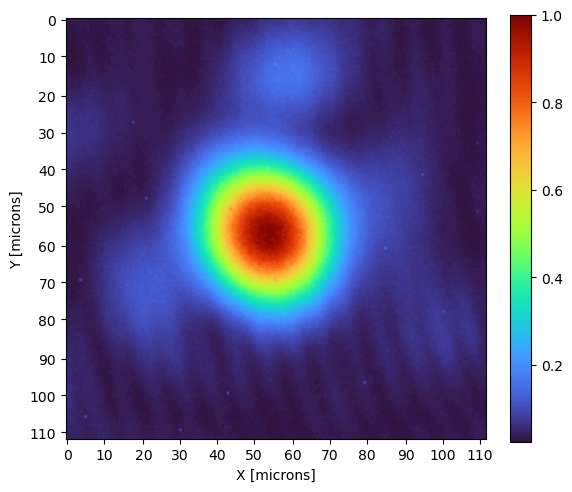

In [199]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

def crop_tiff_around_location(tiff_path, center_x, center_y, crop_size, pixel_size):
    # Load the TIFF file
    image = tifffile.imread(tiff_path)
    
    # Determine the image dimensions
    height, width = image.shape
    
    # Calculate the bounding box for the crop
    half_crop_size = crop_size // 2
    x_min = max(0, center_x - half_crop_size)
    x_max = min(width, center_x + half_crop_size)
    y_min = max(0, center_y - half_crop_size)
    y_max = min(height, center_y + half_crop_size)
    
    # Perform the crop
    cropped_image = image[y_min:y_max, x_min:x_max]
    cropped_image=cropped_image/np.amax(cropped_image)
    
    # Calculate the new center coordinates in the cropped image
    new_center_x = center_x - x_min
    new_center_y = center_y - y_min
    
    # Convert axes to microns
    microns_per_pixel = pixel_size  # Assuming pixel_size is in microns/pixel
    size_in_microns = crop_size * microns_per_pixel
    new_center_x_microns = new_center_x * microns_per_pixel
    new_center_y_microns = new_center_y * microns_per_pixel
    
    # Plot the cropped image
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Display the image
    im = ax.imshow(cropped_image, cmap='turbo')
    
    # Set plot title and labels in microns
    ax.set_xlabel('Microns')
    ax.set_ylabel('Microns')
    
    # Calculate tick positions in microns
    x_ticks_microns = np.linspace(0, size_in_microns, 5)
    y_ticks_microns = np.linspace(0, size_in_microns, 5)
    
    # Set tick labels
    ax.set_xticks(x_ticks_microns, [f'{tick:.1f}' for tick in x_ticks_microns])
    ax.set_yticks(y_ticks_microns, [f'{tick:.1f}' for tick in y_ticks_microns])

    change_ticks(data=cropped_image,pixsize=0.7,axis=ax,change_X=True,change_Y=True)
    
    plt.colorbar(im, ax=ax,fraction=0.046)
    
    return cropped_image

# Example usage:
tif_path = 'shot_1.tiff'  # Replace with your TIFF file path
center_x = 640  # Replace with desired center x coordinate
center_y = 430  # Replace with desired center y coordinate
crop_size = 160  # Replace with desired crop size (in pixels)
pixel_size = 0.7  # Replace with your pixel size in microns

cropped_image = crop_tiff_around_location(tif_path, center_x, center_y, crop_size, pixel_size)
